NOT NEEDED : FIXED (1)

In [1]:
%env CUDA_VISIBLE_DEVICES= 1


env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'

## IndicTrans2

In [3]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)

cuda


In [4]:
import transformers
print(transformers.__version__)

4.44.2


In [5]:
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)

pir= poss_indic_rel.possible_relations
pir

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings

In [6]:
# span_encodings['ory_Orya']

In [7]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

In [8]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir,  quantization)

ip_en_ind = IndicProcessor(inference=True)

# Util Functions

In [9]:


def resolve_logits_for_best_beam(outputs, num_beams):
    """ Resolve the logits from the best beam, using model output from a generate call.
        For a shape [tokens?, batch_size*num_beams, vocab], returns [tokens?, batch_size, vocab]

        Assumes num_return_sequences=1."""

    # print("length of output beam", len(outputs.beam_indices))
    # print("shape of beam_indices", outputs.beam_indices.shape)
    # print("shape of logits", (outputs.logits[0].shape))
    # print("length of logits", len(outputs.logits))
    # print("length od outputs", len(outputs))
    best_logits = []
    beam_indices = []
    for i in range(len(outputs.logits) - 1):
        beam_indices.append(outputs.beam_indices[:, i-1].tolist()) 
    # print("length of beam_indices", len(beam_indices))
    # print("beam_indices", beam_indices)
    for beam_index, logits in zip(beam_indices, outputs.logits):
        beam_index = [ idx if idx != -1 else ((num_beams*(i+1))-1) for i, idx in enumerate(beam_index) ]
        best_logits.append(logits[beam_index,:])

    return best_logits




def get_logits_for_span(logits, translations, tokenizer, search_spans, span_encodings, lang):
    """ Given search spans, returns the logits before the span was generated.

    Args:
        logits (tuple[Tensor]): Tuple of tensors, of shape [tokens?, batch_size, vocab]
        sequences (tuple[list[int]]): Tokenized output sequences.
        tokenizer (PreTrainedTokenizerBase): Tokenizer for the model.
        search_spans (list[str]): batch_size spans to search for. Must be present in the generated sequences.

    Returns:
        Tensor: Tensor of shape [batch_size, vocab] indicating the logits before the span for each batch element.
    """
    if isinstance(search_spans, str):
        search_spans = [ search_spans ] * len(translations)

    # with tokenizer.as_target_tokenizer():   
    #     detok_outputs = tokenizer.batch_decode(translations, skip_special_tokens=True)

    # positions = [ output.index(span) for output, span in zip(translations, search_spans) ]
    logit_pos = [  ]

    for seq,  span,  in zip(translations,  search_spans): 
        # print("Span to search for:", span, span_encodings[lang])
        key = next((k for k in span_encodings[lang].keys() if span in k), "None")
        subtokens = span_encodings[lang][key]
        print("subtokens", subtokens)
        print("for span:", span, "subtokens", subtokens)
        print("seq", seq)
        idx = 0
        while idx < len(seq)-1:
            if any(idx+i < len(seq) and seq[idx+i] == tok for i, tok in enumerate(subtokens)): 
                # print( "found", idx)
                break
            idx += 1
        logit_pos.append(idx-1)
    
    print("logit_pos", logit_pos)
    print("Dimensions of logits", logits[0].shape, len(logits))

    selected_logits = []
    # Iterate over each batch and corresponding token position
    for batch, token in enumerate(logit_pos):
        print("batch, token", batch, token)
        print("len(logits)", len(logits))
        print("Shape of logits", logits[0].shape)
        # print("logits token", logits[token])
        print("logits 1st item 1st row",logits[0][0])
        # Extract logits for the specific token position in the current batch
        current_logit = logits[token][batch, :]
        # current_logit = logits[token][0]
        
        # Append the selected logit to the list
        selected_logits.append(current_logit)

    # Stack the list of selected logits into a tensor
    selected_logits = torch.stack(selected_logits)

    return selected_logits
        
    # return selected_logits
    # return torch.stack([ logits[token][batch,:] for batch, token in enumerate(logit_pos) ])


In [10]:
def get_search_spans(inp_sents, tgt_lang, translations):
    search_spans= []
    root_amb_words=[]
    # print("inp_sents", inp_sents)
    for idx, inp in enumerate(inp_sents):
        # check which word from ambiguos_Wwords in present in the input sentence
        for word in ambiguos_words:
            if word in inp:
                curr_amb_word= word
        root_amb_words.append(curr_amb_word)

        # get the possible relations for the current ambiguous word
        possible_relations= pir[curr_amb_word][tgt_lang].keys()
        # print("Possible relations for the word", curr_amb_word, "in", tgt_lang, "are", possible_relations)

        # find the word in the translation from the possible relations. if not found print the translation
        for rel in possible_relations:
            if rel in translations[idx]:
                # print("Relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx], "at ", translations[idx].index(rel), "\nso sentece is", translations[idx][translations[idx].index(rel):])
                search_spans.append(rel)
                break
        else:
            # print("No relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx])
            search_spans.append(translations[idx][0])
    # print("Search spans are", search_spans)
    return root_amb_words, search_spans
       



In [11]:



def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, span_encodings):
    translations = []
    start_logits = []
    root_amb_words = []
    searched_spans = []
    for i in tqdm(range(0, len(input_sentences), BATCH_SIZE)):
        batch = input_sentences[i : i + BATCH_SIZE]
        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)
        with torch.no_grad():
            # generated_tokens = model.generate(
            outputs = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1, # TODO temp
                output_scores=True,
                output_logits=True,
                return_dict_in_generate=True,

            )
            # print("Length of outputs.logits actual", len(outputs.logits))
            # print("Shape of outputs.logits actual", outputs.logits[0].shape)

            # print("Length of outputs.beam_indices actual", len(outputs.beam_indices))
            # print("Shape of outputs.beam_indices actual", outputs.beam_indices.shape)
            
            outputs.beam_indices = outputs.beam_indices.cpu()
            outputs.logits = tuple(logits.cpu() for logits in outputs.logits)               
        # Decode the generated tokens into text
        generated_tokens = outputs.sequences
        # print("len generated_tokens: ", (generated_tokens[0]).shape)
        # print("1st generated token: ", generated_tokens[0])
        vector = generated_tokens.detach().cpu().tolist()
        # print("length of outputs vectors: ", len(vector), len(vector[0]))
        # print("vector of generated_tokens: ", vector)
        # print("1st vector: ", vector[0])



        with tokenizer.as_target_tokenizer():
            decoded_op = tokenizer.batch_decode(
                vector,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # print("1st decoded_op: ", decoded_op[0])
        # Postprocess the translations, including entity replacement
        transl = ip.postprocess_batch(decoded_op, lang=tgt_lang)

        # print("translations: ", transl)
        

        root_words, search_spans = get_search_spans(batch,  tgt_lang, transl)
        searched_spans += search_spans
        root_amb_words += root_words
        # print("length search_spans: ", len(search_spans))
        best_logits = resolve_logits_for_best_beam(outputs, num_beams=5)
        # print("length best_logits: ",len(best_logits))
        # print("length of best_logits: ", len(best_logits), (best_logits[0]).shape)

        start_logits += get_logits_for_span(best_logits, outputs.sequences, tokenizer, search_spans, span_encodings, tgt_lang)
        # start_logits += get_logits_for_span(best_logits, translations, tokenizer, search_spans)
        translations += transl
        del inputs
        torch.cuda.empty_cache()

    return translations, start_logits, root_amb_words, searched_spans

In [12]:
lang_script_list = [  'tel_Telu',
                           ]

In [13]:
test_csv_folder = 'custom_test_csv'

In [14]:
lang_code_map = {
    'eng_Latn': 'en',
    'hin_Deva': 'hi',
    'guj_Gujr': 'gu',
    'kan_Knda': 'kn',
    'mal_Mlym': 'ml',
    'mar_Deva': 'mr',
    'tam_Taml': 'ta',
    'tel_Telu': 'te',
    'pan_Guru': 'pa',
    'ben_Beng': 'bn',
    'ory_Orya': 'or'
}


In [15]:
sents = []
with open('test_sentences_eng.txt', 'r') as f:
    sents = f.readlines()
sents = [sent.strip() for sent in sents if sent.find('child')==-1]
print(len(sents))

1809


In [16]:
# SAMPLE_SIZE = 10
SAMPLE_SIZE = len(sents)
sents = sents[:SAMPLE_SIZE]
# sents

# Execute Translations

In [17]:
src_lang = "eng_Latn"
output_trnsl={}
output_logits={}

for lang in lang_script_list:
    tgt_lang = lang
    print(lang)
    # if tgt_lang != 'ory_Orya':
    #     continue
    translations, logits, root_amb_words, searched_spans = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind, span_encodings)
    output_trnsl[lang] = translations
    output_logits[lang] = logits


tel_Telu


  0%|          | 0/453 [00:00<?, ?it/s]/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
  0%|          | 1/453 [00:00<05:45,  1.31it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,   151, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 7, 7, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2793, -1.2793,  0.6104,  ..., -1.2793, -1.2793, -1.2793],
       dtype=torch.float16)
batch, token 1 7
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row 

  0%|          | 2/453 [00:01<04:11,  1.79it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360, 56061,  3494,   728,     4,     2,     1,     1],
       device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 56061,  3494,   728,     4,     2],
       device='cuda:0')
logit_pos [8, 1, 8, 1]
Dimensions of logits torch.Size([4, 122672]) 11
batch, token 0 8
len(logits) 11
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.9868, -0.9863,  0.6440,  ..., -0.9868, -0.9863, -0.9863],
       dtype=torch.float16)
batch, token 1 1
len(logits

  1%|          | 3/453 [00:01<03:32,  2.12it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 64275, 20903,     4,     2,     1,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552, 64275,   289,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 64275,   289,     4,     2,     1,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 8, 8]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0410, -1.0410,  0.5513,  ..., -1.0410, -1.0410, -1.0410],
       dtype=torch.float16)
batch, token 1 1
len(logits) 10
Shape o

  1%|          | 4/453 [00:01<03:06,  2.40it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 64275, 20903,     4,     2,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 64275,     4,     2],
       device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621, 64275, 20903,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432, 64275,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 1, 7]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1650, -1.1641,  0.9722,  ..., -1.1641, -1.1650, -1.1650],
       dtype=torch.float16)
batch, token 1 1
len(logits) 9
Shape of logits 

  1%|          | 5/453 [00:02<02:52,  2.59it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 64275,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 64275, 20903,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476,   151, 66319, 20903,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,   151, 66319,  4645,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1, 1, 7]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8555, -0.8555,  0.6011,  ..., -0.8555, -0.8555, -0.8550],
       dtype=torch.float16)
batch, token 1 1
len(logits) 9
Shape of logits torch.Size([4, 122672]

  1%|▏         | 6/453 [00:02<02:49,  2.64it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151, 66319,  4645,     4,     2,     1,     1,
            1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,   151, 66319, 20903,     4,     2,     1,     1,
            1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   151, 66319,  4645,     4,
            2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,   151, 66319, 20903,     4,     2,     1,
            1], device='cuda:0')
logit_pos [9, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 9
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.3350, -1.3350,  0.9951,  ..., -1.3350, -1.3350, -1.3350],
       dtype=torch.float1

  2%|▏         | 7/453 [00:02<02:44,  2.71it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432,   151, 66319,  4645,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   151, 66319,  4645,     4,     2],
       device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   151, 66319, 20903,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476,   151, 69522, 20903,     4,     2,     1],
       device='cuda:0')
logit_pos [3, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 3
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1113, -1.1104,  0.9380,  ..., -1.1113, -1.1104, -1.1104],
       dtype=torch.float16)
batch, token 1 1
len(logits) 

  2%|▏         | 8/453 [00:03<02:44,  2.71it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552,   151, 69522,  4645,     4,     2,     1,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  9971,   151, 69522,  4645,     4,     2,     1,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,   151, 69522, 20903,     4,     2,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 69522,  4645,     4,     2],
       device='cuda:0')
logit_pos [2, 2, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 2
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8735, -0.8735,  0.9600,  ..., -0.8735, -0.8735, -0.8735],
       dtype=torch.float16)
batch, token 1 2
l

  2%|▏         | 9/453 [00:03<02:38,  2.80it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  1978,   104,   124, 69522, 20903,     4,     2],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432, 69522,  4645,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 69522,  4645,     4,     2],
       device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 69522, 20903,     4,     2],
       device='cuda:0')
logit_pos [7, 2, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 7
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8218, -0.8218,  1.0361,  ..., -0.8218, -0.8218, -0.8218],
       dtype=torch.float16)
batch, token 1 2
len(logits) 9
Shape of logits to

  2%|▏         | 10/453 [00:03<02:32,  2.90it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2,  354, 1774, 1476, 4577, 1138,  728,    4,    2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,  4577,  1138,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151,  4577,  1138,   728,     4,     2],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,  4577,  1138,   728,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 7, 7, 1]
Dimensions of logits torch.Size([4, 122672]) 8
batch, token 0 1
len(logits) 8
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1504, -1.1494,  0.8662,  ..., -1.1504, -1.1504, -1.1504],
       dtype=torch.float16)
batch, token 1 7
len(logits) 8
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1504,

  2%|▏         | 11/453 [00:04<02:34,  2.86it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  4577,  1138,   728,     4,
            2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([   2,   46, 1978,  104,  124, 4577, 1138,  728,    4,    2,    1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  4577,  1138,   728,     4,     2,     1,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  4577,  1138,   728,     4,     2,
            1], device='cuda:0')
logit_pos [1, 9, 9, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8481, -0.8477,  1.0312,  ..., -0.8477, -0.8477, -0.8477],
       dtype=torch.fl

  3%|▎         | 12/453 [00:04<02:34,  2.85it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 45073, 20903,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476,   151, 18805,  2389,     4,     2],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552,   151, 18805,  2389,     4,     2,     1],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151, 18805,  2389,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1, 7, 7]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.9360, -0.9355,  0.8237,  ..., -0.9360, -0.9360, -0.9360],
       dtype=torch.float16)
batch, token 1 1
len(logits) 10
Shape of logits torch.Size([4, 1226

  3%|▎         | 13/453 [00:05<02:44,  2.67it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,   151, 18805,  2389,     4,     2,     1,     1,
            1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22998,  2558,  3458, 12324,
            4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360,   143,   399,   468, 22998,  2558,  3458,   468,
            4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   151, 18805,  2389,     4,     2,     1,
            1,     1], device='cuda:0')
logit_pos [1, 1, 10, 10]
Dimensions of logits torch.Size([4, 122672]) 12
batch, token 0 1
len(logits) 12
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8149, -0.8140,  1.3682,  ..., -0.8145, -0.

  3%|▎         | 14/453 [00:05<02:44,  2.67it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22998,  2558,  3458, 12324,     4,
            2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22998,  2558,  3458,   468,     4,
            2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22651,  8138,   465,   306,     4,     2,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552, 22651,  8138,   465,   306,     4,     2,     1,
            1], device='cuda:0')
logit_pos [1, 1, 1, 9]
Dimensions of logits torch.Size([4, 122672]) 11
batch, token 0 1
len(logits) 11
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.5322, -0.5322,  1.3545,  ..., -0.5322, -0.5322, -0.5322],
       dtype=torch.floa

  3%|▎         | 15/453 [00:05<02:47,  2.62it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  9971, 22651,  8138,   465,   306,     4,     2,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22651,  8138,   465,   306,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360, 22651,  8138,   465,   306,     4,     2,     1],
       device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621, 22651,  8138,   465,   306,     4,     2],
       device='cuda:0')
logit_pos [8, 1, 8, 1]
Dimensions of logits torch.Size([4, 122672]) 11
batch, token 0 8
len(logits) 11
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0742, -1.0742,  1.2441,  ..., -1.0742, -1.0742, -1.0742],
       dtype=torch.float16)
batch, token 1 1
len(logits) 11


  4%|▎         | 16/453 [00:06<02:46,  2.63it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432, 22651,  8138,   465,   306,     4,     2,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22651,  8138,   465,   306,     4,
            2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22651,  8138,   465,   306,     4,
            2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476,   151,  7376, 15528,     4,     2,     1,
            1], device='cuda:0')
logit_pos [9, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 9
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.7290, -0.7290,  1.5908,  ..., -0.7290, -0.7290, -0.7290],
       dtype=torch.floa

  4%|▍         | 17/453 [00:06<02:42,  2.68it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552,   151,  7376,  2389,     4,     2,     1,     1],
       device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,    46,  9971,  4559,   151,  7376, 15528,     4,     2,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,   151,  7376, 15528,     4,     2,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  7376, 15528,     4,     2],
       device='cuda:0')
logit_pos [8, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 8
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.7305, -0.7305,  1.3496,  ..., -0.7305, -0.7305, -0.7305],
       dtype=torch.float16)
batch, token 1 1
len(logi

  4%|▍         | 18/453 [00:06<02:37,  2.76it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  7376, 15528,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   151,  7376, 15528,     4,     2],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  7376, 15528,     4,     2],
       device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  7376, 15528,     4,     2],
       device='cuda:0')
logit_pos [1, 7, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.5615, -0.5610,  1.6992,  ..., -0.5610, -0.5610, -0.5610],
       dtype=torch.float16)
batch, token 1 7
len(logits) 9
Shape of logits t

  4%|▍         | 19/453 [00:07<02:37,  2.75it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2,   46, 1774, 1476,  151,  110, 1880,  115, 2389,    4,    2],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552,   151,   110,  1880,   115,  2389,     4,     2,
            1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151,   110,  1880,   115,  2389,     4,     2,
            1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,   151,   110,  1880,   115,  2389,     4,     2,
            1], device='cuda:0')
logit_pos [1, 9, 9, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.8184, -0.8179,  1.2021,  ..., -0.8179, -0.8179, -0.8179],
       dtype=torch.float16)
batch, token 1 9
len(logits) 10
S

  4%|▍         | 20/453 [00:07<02:46,  2.61it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   110,  1880,   115,  2389,
            4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([   2,   46,   76, 2621,  151,  110, 1880,  115, 2389,    4,    2,    1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   151,   110,  1880,   115,  2389,     4,
            2,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   110,  1880,   115,  2389,     4,
            2,     1], device='cuda:0')
logit_pos [1, 1, 10, 1]
Dimensions of logits torch.Size([4, 122672]) 12
batch, token 0 1
len(logits) 12
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.6089, -0.6089,  1.5420,  ..., -0.6089, -0.6089, -0

  5%|▍         | 21/453 [00:08<02:46,  2.59it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   110,  1880,   115,  2389,     4,
            2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476,  2091,  3534, 15528,     4,     2,     1,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14552,   151,  2091,  3534, 15528,     4,     2,     1,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  9971,   151,  2091,  3534, 15528,     4,     2,     1,
            1], device='cuda:0')
logit_pos [1, 1, 9, 9]
Dimensions of logits torch.Size([4, 122672]) 11
batch, token 0 1
len(logits) 11
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.6338, -0.6333,  1.3486,  ..., -0.6333, -0.6333, -0.6333],
       dtype=torch.floa

  5%|▍         | 22/453 [00:08<02:48,  2.56it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,  2091,  3534, 15528,     4,     2,     1,     1,
            1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2091,  3534, 15528,     4,
            2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2091,  3534, 15528,     4,     2,     1,
            1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2091,  3534, 15528,     4,     2,     1,
            1], device='cuda:0')
logit_pos [1, 1, 1, 9]
Dimensions of logits torch.Size([4, 122672]) 11
batch, token 0 1
len(logits) 11
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.9331, -0.9326,  1.1475,  ..., -0.9326, -0.9326, -0.9326],
       dtype=

  5%|▌         | 23/453 [00:09<03:03,  2.34it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2091,  3534, 15528,     4,     2,
            1,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2091,  3534, 15528,     4,     2,
            1,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,  2297,  2615,   283, 33082, 49741, 12213,
        18367,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Si

  5%|▌         | 24/453 [00:09<03:18,  2.16it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,  2297,  2615,   283, 33082, 49741, 12213,
        18367,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 1
len(logits) 16
Shape of logits torch.Size([4, 122672])
logits 1s

  6%|▌         | 25/453 [00:10<03:25,  2.09it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297,  2615,   283, 33082, 49741, 12213,  6559,
            4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 22378,  2584,   771,  2615,   283, 33082, 49741,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297,  2615,   283, 33082, 49741, 12213,  6559,
            4,     2,     1,     1,     1,     1], device='cuda:0')
logit_pos [14, 14, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 14
len(logits) 15
Shape of logits torch.Size([4, 122672])


  6%|▌         | 26/453 [00:10<03:29,  2.04it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771,  2615,   283, 33082, 49741,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598,  2615,   283, 33082, 49741,
           76,  4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971,  2297,  2615,   283, 33082, 49741, 12213,  6559,
            4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [14, 14, 14, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 14
len(logits) 15
Shape of logits 

  6%|▌         | 27/453 [00:11<03:38,  1.95it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971,   984, 59731,  1598,  2615,   283, 33082, 49741,
           76,  4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,  2297,  2615,   283, 33082, 49741, 12213,  6559,
            4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [14, 14, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 14
len(logits) 16
Shape of logits torch.Size([4, 1

  6%|▌         | 28/453 [00:11<03:36,  1.96it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,  2297,  2615,   283, 33082, 49741, 12213,  6559,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771,  2615,   283, 33082, 49741,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,   984, 59731,  1598,  2615,   283, 33082, 49741,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297,  2615,   283, 33082, 49741, 12213, 18367,
            4,     2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row t

  6%|▋         | 29/453 [00:12<03:46,  1.87it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771,  2615,   283, 33082, 49741,
          302,  7894,  4856,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598,  2615,   283, 33082, 49741,
           76,  4354,  1188,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297,  2615,   283, 33082,
        49741, 12213, 34555,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22378,  2584,   771,  2615,
          283, 33082, 49741,   302,  7894,  4856,     4,     2],
       device='cuda:0')
logit_pos [1, 1,

  7%|▋         | 30/453 [00:12<03:58,  1.77it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598,  2615,
          283, 33082, 49741,    76,  4354,  1188,     4,     2],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297,  2615,   283, 33082,
        49741, 12213, 34555,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598,  2615,
          283, 33082, 49741,    76,  4354,  1188,     4,     2],


  7%|▋         | 31/453 [00:13<04:06,  1.71it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2297,  2615,   283, 33082, 49741, 12213,
        18367,     4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  1978,   104,   124, 22378,  2584,   771,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,   984, 59731,  1598,    46,    76,  2621,  2615,   283, 33082,
        49741,    76,  4354,  1453,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297,  2615,   283, 33082,
        49741, 12213, 18367,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 15, 4, 1]
Dimensions of logits torch.Size([4, 122672]) 18
batch, tok

  7%|▋         | 32/453 [00:14<04:12,  1.67it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22378,  2584,   771,  2615,
          283, 33082, 49741,   302,  7894,  4856,     4,     2],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598,  2615,
          283, 33082, 49741,    76,  4354,  1188,     4,     2],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297,  2615,   283, 33082, 49741, 12213,
        34555,     4,     2,     1,     1,     1,     1,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 16,

  7%|▋         | 33/453 [00:14<04:08,  1.69it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297,  2615,   283, 33082, 49741, 12213,
        34555,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22378,  2584,   771,  2615,   283, 33082,
        49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598,  2615,   283, 33082,
        49741,    76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [14, 14, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 14
len

  8%|▊         | 34/453 [00:15<04:06,  1.70it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297,  2615,   283, 33082, 49741,
        12213, 34555,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598,  2615,   283,
        33082, 49741,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297,  2615,   283, 33082, 49741,
        12213, 34555,     4,     2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 15]
Dimensions of logits torch.Size([4, 122672]) 17
batch, token

  8%|▊         | 35/453 [00:15<04:01,  1.73it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598,  2615,   283,
        33082, 49741,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297,  2615,   283, 33082, 49741,
        12213, 18367,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [15, 15, 1, 1]
Dimensions of logits torch.Size([

  8%|▊         | 36/453 [00:16<04:01,  1.73it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598,  2615,   283,
        33082, 49741,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297,  2615,   283, 33082, 49741,
        12213, 18367,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771,  2615,   283,
        33082, 49741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598,  2615,   283,
        33082, 49741,    76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([

  8%|▊         | 37/453 [00:16<03:51,  1.80it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,  2297, 49277,   409,   741,    76,  1640,
         5723,     4,     2,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476, 22378,  2584,   771, 49277,   205,   758,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598, 49277,   205,   758,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,  2297, 49277,   409,   741,    76,  1640,
         5723,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.04

  8%|▊         | 38/453 [00:17<03:44,  1.85it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771, 49277,   205,   758,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598, 49277,   205,   758,
           76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297, 49277,   409,   741,    76,  1640,  7991,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269, 22378,  2584,   771, 49277,   205,   758,
          302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [1, 1, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1436, -1

  9%|▊         | 39/453 [00:17<03:37,  1.90it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598, 49277,   205,   758,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297, 49277,   409,   741,    76,  1640,  7991,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771, 49277,   205,   758,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598, 49277,   205,   758,    76,
         4354,  1188,     4,     2,     1], device='cuda:0')
logit_pos [13, 13, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([

  9%|▉         | 40/453 [00:18<03:34,  1.93it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971,  2297, 49277,   205,   758,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771, 49277,   205,   758,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971, 20269,   984, 59731,  1598, 49277,   205,   758,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,  2297, 49277,   205,   758,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
logit_pos [13, 1, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row 

  9%|▉         | 41/453 [00:19<03:39,  1.88it/s]

subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771, 49277,   205,   758,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971, 20269,   984, 59731,  1598, 49277,   205,   758,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,  2297, 49277,   409,   741,    76,  1640,  5723,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771, 49277,   409,   741,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 13, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 1
len(logits) 16
Shape of logits torch.Size([4, 122672])
logits 1st it

  9%|▉         | 42/453 [00:19<03:34,  1.92it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,   984, 59731,  1598, 49277,   205,   758,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297, 49277,   409,   741,    76,  1640,  5723,
            4,     2,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771, 49277,   409,   741,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598, 49277,   205,   758,    76,
         4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2832, -1.2822,  0.

  9%|▉         | 43/453 [00:20<03:37,  1.88it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297, 49277,   409,   741,
           76,  1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22378,  2584,   771, 49277,
          409,   741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598, 49277,
          409,   741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297, 49277,   409,   741,
           76,  1640, 29098,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimension

 10%|▉         | 44/453 [00:20<03:41,  1.85it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22378,  2584,   771, 49277,
          409,   741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 49277,
          409,   741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2297, 49277,   409,   741,    76,  1640,
         5723,     4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  1978,   104,   124, 22378,  2584,   771, 49277,   409,
          741,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 1, 15]
Dimensions of logits torch.Size([4, 1

 10%|▉         | 45/453 [00:21<03:44,  1.82it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,   984, 59731,  1598,    46,    76,  2621, 49277,   409,   741,
           76,  4354,  1453,     4,     2,     1,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,  1420,    76,  2621,  2297, 49277,   409,   741,    76,  1640,
         5723,     4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22378,  2584,   771, 49277,
          409,   741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 49277,
          409,   741,    76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [4, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
bat

 10%|█         | 46/453 [00:21<03:36,  1.88it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297, 49277,   409,   741,    76,  1640,
        29098,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771, 49277,   409,   741,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432,   984, 59731,  1598, 49277,   409,   741,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297, 49277,   409,   741,    76,  1640,
        29098,     4,     2,     1,     1], device='cuda:0')
logit_pos [13, 13, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([4, 1

 10%|█         | 47/453 [00:22<03:35,  1.89it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22378,  2584,   771, 49277,   409,   741,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598, 49277,   409,   741,
           76,  4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297, 49277,   409,   741,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771, 49277,   205,
          758,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [14, 14, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 14
len(logits) 1

 11%|█         | 48/453 [00:22<03:36,  1.87it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598, 49277,   205,
          758,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297, 49277,   409,   741,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771, 49277,   409,
          741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598, 49277,   409,
          741,    76,  4354,  3420,     4,     2], device='cuda:0')
logit_pos [1, 14, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 1
len(l

 11%|█         | 49/453 [00:23<03:35,  1.87it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297, 49277,   409,   741,    76,
         1640,  5723,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771, 49277,   409,
          741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598, 49277,   205,
          758,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297, 49277,   409,   741,    76,
         1640,  5723,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 

 11%|█         | 50/453 [00:23<03:34,  1.88it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771, 49277,   409,
          741,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598, 49277,   409,
          741,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2,  354, 1774, 1476, 2297,  328, 3658,   76, 1640, 5723,    4,    2,
           1,    1,    1,    1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Size([4, 

 11%|█▏        | 51/453 [00:24<03:27,  1.94it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598, 69073,    76,  4354,
         1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2, 1420, 1774, 1476, 2297,  328, 3658,   76, 1640, 5723,    4,    2,
           1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598, 69073,    76,  4354,
         1453,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 1
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2471, -1.2461,  0.5908,  ..., -1.2471, -1.2471, -1.2471],
       dtype=

 11%|█▏        | 52/453 [00:24<03:21,  1.99it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297,   328,  3658,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 22378,  2584,   771, 69073,   302,  7894,  4856,
            4,     2,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598,   328,  3658,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297,   328,  3658,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
logit_pos [12, 12, 12, 12]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 12
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0029, -1.0020,  1.118

 12%|█▏        | 53/453 [00:25<03:18,  2.02it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771, 69073,   302,  7894,  4856,
            4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598, 69073,    76,  4354,  1188,
            4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971,  2297,   328,  3658,    76,  1640, 29098,     4,
            2,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2], device='cuda:0')
logit_pos [11, 11, 11, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 11
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1904e+00, -1.1895e+00,  4

 12%|█▏        | 54/453 [00:25<03:12,  2.07it/s]

subtokens [4272, 6246]
for span: క subtokens [4272, 6246]
seq tensor([    2,   984, 59731,  1598,   354,  9971,   328,  3658,    76,  4354,
         1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,  2297,   328,  3658,    76,  1640, 29098,     4,
            2,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,   984, 59731,  1598, 69073,    76,  4354,  1188,
            4,     2,     1], device='cuda:0')
logit_pos [11, 11, 1, 11]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 11
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.4590, -1.4580,  0.2581,  

 12%|█▏        | 55/453 [00:26<03:06,  2.14it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,  2297,   328,  3658,    76,  1640,  5723,     4,
            2,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771, 69073,   302,  7894,  4856,
            4,     2,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   984, 59731,  1598,   354, 11569,   328,  3658,    76,  4354,
         1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297,   328,  3658,    76,  1640,  5723,     4,
            2,     1,     1], device='cuda:0')
logit_pos [1, 1, 4, 1]
Dimensions of logits torch.Size([4, 122672]) 12
batch, token 0 1
len(logits) 12
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2227, -1.2217,  0.9604,  ..., -1.2217, -1.2227

 12%|█▏        | 56/453 [00:26<03:11,  2.08it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771, 69073,   302,  7894,  4856,
            4,     2,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598, 69073,    76,  4354,  1188,
            4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297,   328,  3658,    76,
         1640, 29098,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22194,   517, 69073,   302,
         7894,  4856,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Size([4, 122672])
logits 1st it

 13%|█▎        | 57/453 [00:27<03:17,  2.01it/s]

subtokens [4272, 6246]
for span: క subtokens [4272, 6246]
seq tensor([    2,   984, 59731,  1598,    46, 19360,   328,  3658,    76,  4354,
         1188,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297,   328,  3658,    76,
         1640, 29098,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517, 69073,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 69073,
           76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [13, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 13
len(logits) 15
Shape of l

 13%|█▎        | 58/453 [00:27<03:22,  1.95it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2297, 69073,    76,  1640,  5723,     4,
            2,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360,   143,   399,   468, 22378,  2584,   771, 69073,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,   984, 59731,  1598,    46,    76,  2621,   328,  3658,    76,
         4354,  1453,     4,     2,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([   2, 1420,   76, 2621, 2297,  328, 3658,   76, 1640, 5723,    4,    2,
           1,    1,    1], device='cuda:0')
logit_pos [1, 13, 4, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Size([4, 122672])
logits 1st item 

 13%|█▎        | 59/453 [00:28<03:26,  1.90it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517, 69073,   302,
         7894,  4856,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 26386,
          148,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297, 69073,    76,  1640, 29098,     4,
            2,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15

 13%|█▎        | 60/453 [00:28<03:19,  1.97it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   984, 59731,  1598, 69073,    76,  4354,
         1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297, 69073,    76,  1640, 29098,     4,
            2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22378,  2584,   771, 69073,   302,  7894,
         4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598, 69073,    76,  4354,
         1188,     4,     2], device='cuda:0')
logit_pos [11, 11, 11, 11]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 11
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([

 13%|█▎        | 61/453 [00:29<03:20,  1.96it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297, 69073,    76,  1640, 29098,
            4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771, 69073,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598, 69073,    76,
         4354,  3420,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297, 69073,    76,  1640, 29098,
            4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 12]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row 

 14%|█▎        | 62/453 [00:29<03:18,  1.97it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771, 69073,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598, 69073,    76,
         4354,  3420,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297,   328,  3658,    76,  1640,
         5723,     4,     2,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771, 69073,   302,
         7894,  4856,     4,     2], device='cuda:0')
logit_pos [12, 12, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 12
len(logits) 14
Shape of logits torch.Size([4, 12267

 14%|█▍        | 63/453 [00:30<03:19,  1.96it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598, 69073,    76,
         4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297, 69073,    76,  1640,  5723,
            4,     2,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771, 69073,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598, 69073,    76,
         4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672

 14%|█▍        | 64/453 [00:30<03:18,  1.96it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2,  354, 1774, 1476, 2297, 5566,  112,  338,   76, 1640, 5723,    4,
           2,    1,    1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598,  5566,   112,   338,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([   2, 1420, 1774, 1476, 2297, 5566,  112,  338,   76, 1640, 5723,    4,
           2,    1,    1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0820, -1.0820,  1.0234,  ..., -1

 14%|█▍        | 65/453 [00:31<03:17,  1.96it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598,  5566,  4754,   420,
           76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297,  5566,   112,   338,    76,  1640,  7991,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 22378,  2584,   771,  5566,   112,   338,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1592, -1

 15%|█▍        | 66/453 [00:31<03:17,  1.96it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598,  5566,   112,   338,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297,  5566,   112,   338,    76,  1640,  7991,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771,  5566,   112,   338,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598,  5566,   112,   338,    76,
         4354,  1188,     4,     2,     1], device='cuda:0')
logit_pos [13, 13, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([

 15%|█▍        | 67/453 [00:32<03:15,  1.98it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971,  2297,  5566,   112,   338,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  9971, 20269,   984, 59731,  1598,  5566,   112,   338,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,  2297,  5566,   112,   338,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
logit_pos [13, 1, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row 

 15%|█▌        | 68/453 [00:32<03:18,  1.94it/s]

subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,   984, 59731,  1598,  5566,   112,   338,    76,
         4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,  2297,  5566,   112,   338,    76,  1640,  5723,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771,  5566,   112,   338,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 13, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Size([4, 122672])
logits 1st it

 15%|█▌        | 69/453 [00:33<03:11,  2.00it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,   984, 59731,  1598,  5566,   112,   338,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297,  5566,   112,   338,    76,  1640,  5723,
            4,     2,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771,  5566,   112,   338,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598,  5566,  4754,   420,    76,
         4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 1
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2998, -1.2988,  0.

 15%|█▌        | 70/453 [00:33<03:18,  1.93it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297,  5566,   112,   338,
           76,  1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22194,   517,  5566,   112,
          338,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598,  5566,
         4754,   420,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297,  5566,   112,   338,
           76,  1640, 29098,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimension

 16%|█▌        | 71/453 [00:34<03:23,  1.88it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517,  5566,   112,
          338,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598,  5566,
         4754,   420,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([   2,   46,   76, 2621, 2297, 5566,  112,  338,   76, 1640, 5723,    4,
           2,    1,    1,    1,    1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  1978,   104,   124, 22378,  2584,   771,  5566,   112,
          338,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 1, 15]
Dimensions of logits torch.Size([4, 122672]) 16
batch,

 16%|█▌        | 72/453 [00:35<03:25,  1.85it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,   984, 59731,  1598,    46,    76,  2621,  5566,  4754,   420,
           76,  4354,  1453,     4,     2,     1,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([   2, 1420,   76, 2621, 2297, 5566,  112,  338,   76, 1640, 5723,    4,
           2,    1,    1,    1,    1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517,  5566,   112,
          338,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598,  5566,
         4754,   420,    76,  4354,  1453,     4,     2], device='cuda:0')
logit_pos [4, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 4
len

 16%|█▌        | 73/453 [00:35<03:18,  1.92it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297,  5566,   112,   338,    76,  1640,
        29098,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   984, 59731,  1598,  5566,   112,   338,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297,  5566,   112,   338,    76,  1640,
        29098,     4,     2,     1,     1], device='cuda:0')
logit_pos [13, 13, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size([4, 1

 16%|█▋        | 74/453 [00:36<03:22,  1.87it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22378,  2584,   771,  5566,   112,   338,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598,  5566,   112,   338,
           76,  4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297,  5566,   112,   338,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771,  5566,   112,
          338,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [14, 14, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 14
len(logits) 1

 17%|█▋        | 75/453 [00:36<03:21,  1.87it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598,  5566,   112,
          338,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297,  5566,   112,   338,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771,  5566,   112,
          338,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598,  5566,  4754,
          420,    76,  4354,  3420,     4,     2], device='cuda:0')
logit_pos [1, 14, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(l

 17%|█▋        | 76/453 [00:37<03:20,  1.88it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297,  5566,   112,   338,    76,
         1640,  5723,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771,  5566,   112,
          338,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598,  5566,  4754,
          420,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297,  5566,   112,   338,    76,
         1640,  5723,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 

 17%|█▋        | 77/453 [00:37<03:19,  1.88it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771,  5566,   112,
          338,   302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598,  5566,  4754,
          420,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,  2297, 47674,   122,    76,  1640,  5723,
            4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits

 17%|█▋        | 78/453 [00:38<03:15,  1.92it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598, 47674,   122,    76,
         4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,  2297, 47674,   122,    76,  1640,  5723,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598, 47674,   122,   148,
           76,  4354,  1453,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.15

 17%|█▋        | 79/453 [00:38<03:13,  1.94it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297, 47674,   122,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 22378,  2584,   771, 47674,   122,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598, 47674,   122,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297, 47674,   122,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
logit_pos [12, 12, 12, 12]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 12
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0244, -1.0244,  1.132

 18%|█▊        | 80/453 [00:39<03:07,  1.99it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771, 47674,   122,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598, 47674,   122,   148,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559,  2297, 47674,   122,    76,  1640, 29098,
            4,     2,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2], device='cuda:0')
logit_pos [12, 12, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 12
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tens

 18%|█▊        | 81/453 [00:39<03:08,  1.97it/s]

subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559,   984, 59731,  1598, 47674,   122,    76,
         4354,  1188,     4,     2,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559,  2297, 47674,   122,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559,   984, 59731,  1598, 47674,   122,   148,
           76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-

 18%|█▊        | 82/453 [00:40<03:03,  2.02it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,  2297, 47674,   122,    76,  1640,  5723,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771, 47674,   122,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,   984, 59731,  1598, 47674,   122,   148,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297, 47674,   122,    76,  1640,  5723,     4,
            2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 1
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.2295, -1.2285,  1.

 18%|█▊        | 83/453 [00:40<03:07,  1.98it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771, 47674,   122,   302,  7894,
         4856,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598, 47674, 13916,    76,  4354,
         1188,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297, 47674,   122,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22378,  2584,   771, 47674,
          122,   302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 

 19%|█▊        | 84/453 [00:41<03:12,  1.91it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598, 47674,
          122,   148,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297, 47674,   122,    76,
         1640, 29098,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22378,  2584,   771, 47674,
          122,   302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 47674,
        13916,    76,  4354,  1188,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimension

 19%|█▉        | 85/453 [00:41<03:13,  1.90it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2297, 47674,   122,    76,  1640,  5723,
            4,     2,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  1978,   104,   124, 22378,  2584,   771, 47674,   122,
          302,  7894,  4856,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598, 47674,
          122,   148,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,  1420,    76,  2621,  2297, 47674,   122,    76,  1640,  5723,
            4,     2,     1,     1,     1,     1,     1], device='cuda:0')
logit_pos [1, 15, 15, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 1


 19%|█▉        | 86/453 [00:42<03:14,  1.89it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,  1420,    76,  2621, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 47674,
        13916,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297, 47674,   122,    76,  1640, 29098,
            4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 16
batch, token 0 1
len(logits) 16
Shape 

 19%|█▉        | 87/453 [00:42<03:08,  1.94it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   984, 59731,  1598, 47674,   122,   148,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297, 47674,   122,    76,  1640, 29098,
            4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22378,  2584,   771, 47674,   122,   302,
         7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598, 47674,   122,   148,
           76,  4354,  1188,     4,     2], device='cuda:0')
logit_pos [13, 13, 13, 13]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits 

 19%|█▉        | 88/453 [00:43<03:09,  1.92it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297, 47674,   122,    76,  1640,
        29098,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771, 47674,   122,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598, 47674,   122,
          148,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297, 47674,   122,    76,  1640,
        29098,     4,     2,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 14]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of

 20%|█▉        | 89/453 [00:43<03:10,  1.91it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771, 47674,   122,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598, 47674,   122,
          148,    76,  4354,  3420,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297, 47674,   122,    76,  1640,
         5723,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771, 47674,   122,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
logit_pos [14, 14, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 

 20%|█▉        | 90/453 [00:44<03:16,  1.85it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598, 47674,   122,
          148,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297, 47674,   122,    76,  1640,
         5723,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771, 47674,   122,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598, 47674, 13916,
           76,  4354,  1188,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 

 20%|██        | 91/453 [00:44<03:08,  1.92it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,  2297, 50191,  1132,    76,  1640,  5723,
            4,     2,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 22378,  2584,   771, 50191,  1132,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,  2297, 50191,  1132,    76,  1640,  5723,
            4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 1
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.0439, -1.0430,  1.0674,  ..., 

 20%|██        | 92/453 [00:45<03:04,  1.96it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 22378,  2584,   771, 50191,  1132,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1453,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,  2297, 50191,  1132,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2, 30539, 20269, 22378,  2584,   771, 50191,  1132,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 12, 12]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1465, -1.1455,  0.0414, 

 21%|██        | 93/453 [00:45<03:00,  1.99it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,  2297, 50191,  1132,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 22378,  2584,   771, 50191,  1132,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   984, 59731,  1598, 50191,  1132,    76,  4354,
         1188,     4,     2,     1], device='cuda:0')
logit_pos [12, 12, 12, 12]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 12
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 

 21%|██        | 94/453 [00:46<02:57,  2.02it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,  2297, 50191,  1132,    76,  1640,  7991,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559, 22378,  2584,   771, 50191,  1132,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,   354,  9971,  4559,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,  2297, 50191,  1132,    76,  1640, 29098,     4,
            2,     1,     1,     1], device='cuda:0')
logit_pos [12, 1, 1, 12]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 12
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.3037, -1.3027

 21%|██        | 95/453 [00:46<02:57,  2.02it/s]

subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 22378,  2584,   771, 50191,  1132,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569,  2297, 50191,  1132,    76,  1640,  5723,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 22378,  2584,   771, 50191,  1132,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 1
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.3018, -1.3008,  0.0547

 21%|██        | 96/453 [00:47<02:52,  2.06it/s]

subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,   354, 11569,   984, 59731,  1598, 50191,  1132,    76,  4354,
         1188,     4,     2,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,  2297, 50191,  1132,    76,  1640,  5723,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 22378,  2584,   771, 50191,  1132,   302,  7894,
         4856,     4,     2,     1], device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   984, 59731,  1598, 50191,  1132,   148,    76,
         4354,  1188,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 13
batch, token 0 1
len(logits) 13
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.1875, -1.1865,  0.

 21%|██▏       | 97/453 [00:47<02:59,  1.98it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,  2297, 50191,  1132,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468, 22194,   517, 50191,  1132,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,    46, 19360,   143,   399,   468,   984, 59731,  1598, 50191,
         1132,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,  2297, 50191,  1132,    76,
         1640, 29098,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 1

 22%|██▏       | 98/453 [00:48<03:04,  1.93it/s]

subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468, 22194,   517, 50191,  1132,
          302,  7894,  4856,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: బావమరిది subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 50191,
         1132,   148,    76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,  2297, 50191,  1132,    76,  1640,  5723,
            4,     2,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621, 22194,   517, 50191,  1132,   302,  7894,
         4856,     4,     2,     1,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 1

 22%|██▏       | 99/453 [00:48<03:07,  1.89it/s]

subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1453,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,  1420,    76,  2621,  2297, 50191,  1132,    76,  1640,  5723,
            4,     2,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,  1420,    76,  2621, 22194,   517, 50191,  1132,   302,  7894,
         4856,     4,     2,     1,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360,   143,   399,   468,   984, 59731,  1598, 50191,
         1132,   148,    76,  4354,  1453,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 16
batch, tok

 22%|██▏       | 100/453 [00:49<03:01,  1.94it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,  2297, 50191,  1132,    76,  1640, 29098,
            4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852, 22378,  2584,   771, 50191,  1132,   302,
         7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,   110, 14852,   984, 59731,  1598, 50191,  1132,    76,
         4354,  1188,     4,     2], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,  2297, 50191,  1132,    76,  1640, 29098,
            4,     2,     1,     1], device='cuda:0')
logit_pos [12, 12, 12, 12]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 12
len(logits) 14
Shape of logits torch.Size([4, 122672])
logits 1st item 1st 

 22%|██▏       | 101/453 [00:49<02:59,  1.96it/s]

subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432, 22194,   517, 50191,  1132,   302,  7894,
         4856,     4,     2,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  2922,  3432,   984, 59731,  1598, 50191,  1132,   148,
           76,  4354,  1188,     4,     2], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,  2297, 50191,  1132,    76,  1640,
        29098,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645, 22378,  2584,   771, 50191,  1132,
          302,  7894,  4856,     4,     2], device='cuda:0')
logit_pos [13, 13, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 14
batch, token 0 13
len(logits) 14
Shape of logits torch.Size

 23%|██▎       | 102/453 [00:50<03:00,  1.95it/s]

subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 14581,   471,  4645,   984, 59731,  1598, 50191,  1132,
           76,  4354,  3420,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,  2297, 50191,  1132,    76,  1640,
        29098,     4,     2,     1,     1,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645, 22378,  2584,   771, 50191,  1132,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14581,   471,  4645,   984, 59731,  1598, 50191,  1132,
          148,    76,  4354,  3420,     4,     2], device='cuda:0')
logit_pos [1, 14, 14, 14]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(l

 23%|██▎       | 103/453 [00:50<03:01,  1.93it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,  2297, 50191,  1132,    76,  1640,
         5723,     4,     2,     1,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 22378,  2584,   771, 50191,  1132,
          302,  7894,  4856,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563,   984, 59731,  1598, 50191,  1132,
           76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,  2297, 50191,  1132,    76,  1640,
         5723,     4,     2,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of 

 23%|██▎       | 104/453 [00:51<02:59,  1.95it/s]

subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563, 22378,  2584,   771, 50191,  1132,
          302,  7894,  4856,     4,     2,     1], device='cuda:0')
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,  1420, 14581,   307, 12563,   984, 59731,  1598, 50191,  1132,
          148,    76,  4354,  1453,     4,     2], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476, 33544,   365,     4,     2,     1,     1,
            1,     1,     1,     1,     1,     1], device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476, 33544,   365,     4,     2,     1,     1,
            1,     1,     1,     1,     1,     1], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 15
batch, token 0 1
len(logits) 15
Shape of logits

 23%|██▎       | 105/453 [00:51<02:45,  2.11it/s]

subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   151, 53906,  3458,   468,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,  1420,  1774,  1476,   151, 53906,  5853,  2726,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552, 20269, 33544,  2628,     4,     2,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552, 20269, 33544,  2628,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 8, 8]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.4775, -1.4766,  0.3735,  ..., -1.4766, -1.4775, -1.4775],
       dtype=torch.float16)
batch, token 1 1
len(logits) 10
Shape of logits 

 23%|██▎       | 106/453 [00:52<02:30,  2.31it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151, 53906,  3458,  5493,     4,     2],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 14552,   151, 53906,  5853, 12245,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 33544,  2628,     4,     2,     1,     1],
       device='cuda:0')
subtokens [9971, 4559]
for span: మామయ్య subtokens [9971, 4559]
seq tensor([    2,  1420,  9971,  4559, 33544,  2628,     4,     2,     1],
       device='cuda:0')
logit_pos [7, 7, 7, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 7
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.3320, -1.3320,  0.6035,  ..., -1.3320, -1.3320, -1.3320],
       dtype=torch.float16)
batch, token 1 7
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st

 24%|██▎       | 107/453 [00:52<02:22,  2.43it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539,   151, 53906,  3458,  5493,     4,     2],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420,  9971,   151, 53906,  5853, 12245,     4,     2],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,    46, 11569, 33544,   365,     4,     2,     1,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569, 33544,   365,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [7, 7, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 10
batch, token 0 7
len(logits) 10
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.6123, -1.6113,  0.5293,  ..., -1.6113, -1.6113, -1.6113],
       dtype=torch.float16)
batch, token 1 7
len(logits) 10
Shape of logits torch.Size([4, 122672]

 24%|██▍       | 108/453 [00:52<02:16,  2.53it/s]

subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476,   151, 53906,  3458,   468,     4,     2],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor([    2,  1420, 11569,   151, 53906,  5853,  2726,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360, 33544, 14235,     4,     2,     1,     1,     1],
       device='cuda:0')
subtokens [19360, 143, 399, 468]
for span: వ subtokens [19360, 143, 399, 468]
seq tensor([    2,  1420, 19360, 33544, 14235,     4,     2,     1,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 8, 1]
Dimensions of logits torch.Size([4, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-1.7061, -1.7051,  0.1321,  ..., -1.7051, -1.7051, -1.7051],
       dtype=torch.float16)
batch, token 1 1
len(logits) 9
Shape of

 24%|██▍       | 108/453 [00:53<02:50,  2.03it/s]


IndexError: index 10 is out of bounds for dimension 1 with size 10

In [ ]:
# dataframe from the translations, logits and the root ambiguous words, searched spans
import pandas as pd

df = pd.DataFrame()
df['sentences'] = sents
df['root_ambiguous_words'] = root_amb_words
for lang in lang_script_list:
    # if lang != 'ory_Orya':
    #     continue
    # following 2 can be commented out to reduce the size of the dataframe
    df['searched_spans_'+lang] = searched_spans
    df['transl_'+lang_code_map[lang]] = output_trnsl[lang]
    df['logits_'+lang_code_map[lang]] = output_logits[lang]

df.head()

,sentences,root_ambiguous_words,searched_spans_tel_Telu,transl_te,logits_te
0,My grandmother is a Brahmin.,grandmother,అమ్మమ,మా అమ్మమ్మ బ్రాహ్మణుడు.,"[tensor(-1.6807, dtype=torch.float16), tensor(..."
1,My grandfather is a Brahmin.,grandfather,మ,మా తాత ఒక బ్రాహ్మణుడు.,"[tensor(-1.0742, dtype=torch.float16), tensor(..."
2,My uncle is a Brahmin.,uncle,మ,మా నాన్న బ్రాహ్మణుడు.,"[tensor(0.0088, dtype=torch.float16), tensor(0..."
3,My aunt is a Brahmin.,aunt,అత్త,నా అత్త బ్రాహ్మణుడు.,"[tensor(-1.6035, dtype=torch.float16), tensor(..."
4,My brother-in-law is a Brahmin.,brother-in-law,న,నా బావ బ్రాహ్మణుడు.,"[tensor(-0.2654, dtype=torch.float16), tensor(..."


In [ ]:
# for all sentences:
#    for all langs:
#     for the given root ambiguous word, get the possible relations in the target language
#      group the possible relations into matriarchal and patriarchal
#       <*>find the logits for the words in matrirachi and patriachal relations
#       find the sum over respective sets and take difference of both sums
#       if difference is positive, then the wordXlang is matriarchal, else patriarchal
#     Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix


In [ ]:
final_res={}

In [ ]:
# for each row of dataframe with index i
for i in range(len(df)):
    # print("Index: ", i)
    for lang in lang_script_list:
        # if lang != 'ory_Orya':
        #     continue
        # print("Lang: ", lang)
        if final_res.get(lang, None) is None:
            final_res[lang] = {}
        root_amb_word = df.loc[i, 'root_ambiguous_words']
        # print("Root ambiguous word: ", root_amb_word)
        possible_relations = list(pir[root_amb_word][lang].keys())
        # print("Possible relations: ", possible_relations)
        matriarchal = []
        patriarchal = []
        for rel in possible_relations:
            if 'F' == pir[root_amb_word][lang][rel]['relation_code']:
                matriarchal.append(rel)
            if 'M' == pir[root_amb_word][lang][rel]['relation_code']:
                patriarchal.append(rel)
        # print("for lang: ", lang, "root amb word: ", root_amb_word, "matriarchal: ", matriarchal, "patriarchal: ", patriarchal)
        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        # print("Logits: ", logits)
        matriarchal_logits = []
        patriarchal_logits = []
        for relations in [matriarchal, patriarchal]:
            for rel in relations:
                # print("for reln:", rel, "span_encodings:", span_encodings[lang].get(rel, None))
                # if rel is present in any key of span_encodings[lang], then print its value
                key = next((k for k in span_encodings[lang].keys() if rel in k), "None")
                word_index = span_encodings[lang].get(key, None)
                # print("for reln::", rel, "Index::", word_index)
                
                # find the avg of the logits for the word_index
                if word_index is not None:
                    avg_logits = torch.mean(logits[word_index], dim=0)
                    # print("Avg logits: ", avg_logits)
                    if relations == matriarchal:
                        matriarchal_logits.append(avg_logits)
                    else:
                        patriarchal_logits.append(avg_logits)

        # print("Matriarchal sets: ", matriarchal_logits, "Patriarchal sets: ", patriarchal_logits)

        # combine arrays of matriarchal and patriarchal logits and find softmax over the new resultant array and separate the matriarchial and patriarchial logits
        if matriarchal_logits and patriarchal_logits:
            effective_logits = torch.stack(matriarchal_logits)
            effective_logits = torch.cat((effective_logits, torch.stack(patriarchal_logits)))
            effective_logits = softmax(effective_logits, dim=0)
            matriarchal_logits_softmax = effective_logits[:len(matriarchal_logits)]
            patriarchal_logits_softmax = effective_logits[len(matriarchal_logits):]

            diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax)) 
            # /tmp/ipykernel_1975081/1980739227.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
            print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff.item())
            # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")
            final_res[lang][root_amb_word] = diff.item()
        else:
            final_res[lang][root_amb_word] = 0
            print(f"Skipping word: {root_amb_word} in lang: {lang} due to empty logits.")



        # find the sum over respective sets and take difference of both sums
        # diff = torch.sum(torch.tensor(matriarchal_logits)) - torch.sum(torch.tensor(patriarchal_logits))
        # print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff)
        # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")

        # #Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix
        # final_matrix[root_amb_word][lang] = diff

        #     matriarchal_logits.append(logits[]
        # print("Matriarchal sets: ", matriarchal, "Patriarchal sets: ", patriarchal)




For word:  grandmother in lang:  tel_Telu Difference:  0.6171875
Skipping word: grandfather in lang: tel_Telu due to empty logits.
For word:  uncle in lang:  tel_Telu Difference:  0.193359375
Skipping word: aunt in lang: tel_Telu due to empty logits.
Skipping word: brother-in-law in lang: tel_Telu due to empty logits.
Skipping word: sister-in-law in lang: tel_Telu due to empty logits.
For word:  cousin in lang:  tel_Telu Difference:  -0.30908203125
For word:  nephew in lang:  tel_Telu Difference:  0.7236328125
For word:  niece in lang:  tel_Telu Difference:  -0.603515625
For word:  grandmother in lang:  tel_Telu Difference:  0.8818359375


/tmp/ipykernel_3720292/2259655106.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax))


In [ ]:
final_res

{'tel_Telu': {'grandmother': 0.8818359375,
  'grandfather': 0,
  'uncle': 0.193359375,
  'aunt': 0,
  'brother-in-law': 0,
  'sister-in-law': 0,
  'cousin': -0.30908203125,
  'nephew': 0.7236328125,
  'niece': -0.603515625}}

In [ ]:
# make a 2D array of the final_res.. not dataframe but 2D array
confusion_mat =[[final_res[lang][word] for j,lang in enumerate(lang_script_list)] for i,word in enumerate(ambiguos_words) if word!='child' ]
confusion_mat

[[0.8818359375],
 [0],
 [0.193359375],
 [0],
 [0],
 [0],
 [-0.30908203125],
 [0.7236328125],
 [-0.603515625]]

In [ ]:
# write to file named "logits_confusion_matrix.txt", put heading as the languages used. next line all ambiguos words, next lines the confusion matrix
with open('logits_confusion_matrix.txt', 'a') as f:
    f.write("Sample size: "+str(SAMPLE_SIZE))
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in confusion_mat:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.close()

/tmp/ipykernel_3720292/4283673118.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(lang_code_map[lang] for lang in final_res.keys()))
/tmp/ipykernel_3720292/4283673118.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(final_res[lang_script_list[0]].keys()))


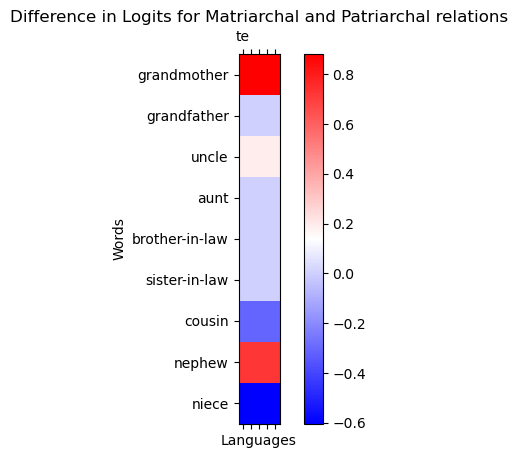

In [ ]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# give colour custommed as max value as Pink and min value as blue and 0 as white
cax = ax.matshow(confusion_mat, cmap='bwr')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(lang_code_map[lang] for lang in final_res.keys()))
ax.set_yticklabels([''] + list(final_res[lang_script_list[0]].keys()))
plt.xlabel('Languages')
plt.ylabel('Words')
plt.title('Difference in Logits for Matriarchal and Patriarchal relations')
# save the image to a file
fig.savefig('results/logit_prob_diff_'+str(SAMPLE_SIZE)+'Telugu.png')
plt.show()



In [ ]:
# index of ['ମାମୁଁ', 'ମଉସା'] in vocab of en_indic_tokenizer
# print(en_indic_tokenizer.convert_tokens_to_ids(['ମାମୁଁ', 'ମଉସା'])) #[3, 3] - wrong

# print(en_indic_tokenizer.vocab



In [ ]:
# # import the test_sentences_eng.txt file data as sents

# # sents = ['The river is blue.', 'My uncle wearing blue coat.', 'My maternal aunt went to the river bank.', "The doctor went to bank for money."]
# sents=['My maternal aunt went to the river bank.', 'My maternal aunt loves me.', 
#        'My maternal aunt loves her grandchildren.', "My maternal aunt loves her children.", 
#        "My maternal aunt loves her family.",
#        ]   
# src_lang = "eng_Latn"

# tgt_lang = 'hin_Deva'
# # print(lang)
# translations, logits = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind)


In [ ]:
print(translations)

['మా అమ్మమ్మ బ్రాహ్మణుడు. ', 'మా తాత ఒక బ్రాహ్మణుడు. ', 'మా నాన్న బ్రాహ్మణుడు. ', 'నా అత్త బ్రాహ్మణుడు. ', 'నా బావ బ్రాహ్మణుడు. ', 'నా వదిన బ్రాహ్మణుడు. ', 'నా బంధువు బ్రాహ్మణుడు. ', 'నా మేనల్లుడు బ్రాహ్మణుడు. ', 'నా మేనకోడలు బ్రాహ్మణుడు. ', 'నా అమ్మమ్మ క్షత్రియురాలు. ']


In [ ]:
print(logits)

tensor([-1.2129, -1.2129, -0.5757,  ..., -1.2129, -1.2129, -1.2129],
       dtype=torch.float16)


In [ ]:
# for each logit in logits, convert it to prob using softmax
softmax_logits=[]
for lang in lang_script_list:
    print(lang)
    
    logits = output_logits[lang]
    softmax_logits = [softmax(logit, dim=-1) for logit in logits]
    # print(softmax_logits)
    # print(len(softmax_logits) ) # for each sentence translated)
    # print(softmax_logits[0].shape) # for each word in the sentence; vocab size

    max_prob_index = [torch.argmax(softmax_logit, dim=-1) for softmax_logit in softmax_logits]
    print(max_prob_index)

    top_10_indices = [torch.topk(softmax_logit, k=10, dim=-1) for softmax_logit in softmax_logits]
    print(top_10_indices)
    # from the top_10_indices, get the words in Hindi vocab using tokenizer.target_tokenizer
    word_list = []
    for i in top_10_indices:
        with en_indic_tokenizer.as_target_tokenizer():
            word_list.append(en_indic_tokenizer.batch_decode(i.indices))
    print(word_list)

# for each sentence, amongs all vocab logits, find the difference of [sum of matrirach words] - [sum of patriarch words]
# find the root word in english and as per lang, find the other Matriarch or Patriarch words based on relation code 

tel_Telu
[tensor(1774), tensor(2), tensor(2), tensor(11569), tensor(4), tensor(76), tensor(2), tensor(14581), tensor(14581), tensor(1774)]
[torch.return_types.topk(
values=tensor([0.9185, 0.0129, 0.0085, 0.0042, 0.0032, 0.0026, 0.0025, 0.0020, 0.0014,
        0.0013], dtype=torch.float16),
indices=tensor([ 1774, 30539,   336,  5457,  4965,   213, 19875, 14552,  1331,  2224])), torch.return_types.topk(
values=tensor([8.4619e-01, 1.6251e-02, 6.2866e-03, 5.0316e-03, 7.4530e-04, 6.2275e-04,
        5.4741e-04, 4.6444e-04, 4.3631e-04, 3.7622e-04], dtype=torch.float16),
indices=tensor([    2,     4,   354,    46,  1774,   388,  1087, 30539,   580, 14552])), torch.return_types.topk(
values=tensor([9.0430e-01, 3.5477e-04, 1.4842e-05, 1.3828e-05, 6.0797e-06, 4.1127e-06,
        3.5763e-06, 3.5167e-06, 3.2783e-06, 3.2187e-06], dtype=torch.float16),
indices=tensor([   2,    4,    7,    6,    5,   13,   30, 2207, 2108,   22])), torch.return_types.topk(
values=tensor([0.6216, 0.0261, 0.0232, 0.0166

/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


# CONCLUSION

Found logits for ambiguos english words just before translating